<a href="https://colab.research.google.com/github/saintblue97/DeepNN_Optiver/blob/main/Copy_of_Sterling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive; drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
#!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v optiver-trading-at-the-close        # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard
!pip install tslearn

- competition is now set to: optiver-trading-at-the-close
Using competition: optiver-trading-at-the-close
  teamId  teamName                                        submissionDate       score     
--------  ----------------------------------------------  -------------------  --------  
10946503  http://t.csdnimg.cn/EJeIV                       2023-10-25 03:31:23  5.3209    
10944891  HAO                                             2023-10-14 00:54:22  5.3340    
10945145  at7459                                          2023-10-25 12:10:13  5.3373    
10957147  iBazhov                                         2023-10-25 10:36:49  5.3374    
10951105  Supreme Taker                                   2023-10-25 04:35:50  5.3393    
10950608  Azusa Mizume                                    2023-10-18 18:16:23  5.3395    
10946116  Rib~                                            2023-10-17 07:02:35  5.3399    
10951223  Double Jason                                    2023-10-25 17:06:14  5.340

In [9]:
%%time
%%capture
%reset -f
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, xgboost, lightgbm as lgb, librosa
from tslearn.clustering import TimeSeriesKMeans
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=300): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 5.95 s, sys: 997 ms, total: 6.95 s
Wall time: 16.1 s


In [10]:
def is_google_colab():
    """Check if the environment is Google Colab.

    Returns:
        bool: True if in Google Colab, False otherwise.
    """
    try:
        import google.colab
        return True
    except ImportError:
      return False

if is_google_colab():
  file_path = ''
else:
  file_path = '/kaggle/input/optiver-trading-at-the-close/'

In [11]:
sample_submission_path = file_path + 'example_test_files/sample_submission.csv'

sample_submission = pd.read_csv(sample_submission_path); sample_submission

,time_id,row_id,target
0,26290,478_0_0,1
1,26290,478_0_1,1
...,...,...,...
32998,26454,480_540_198,1
32999,26454,480_540_199,1


In [12]:
train_data_path = file_path + 'train.csv'
df = pd.read_csv(train_data_path);
df = df.dropna(subset=['target']); df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3.18e+06,1,1.0,1.34e+07,NaN,NaN,1.0,60651.50,1.0,8493.03,1.0,-3.03,0,0_0_0
1,1,0,0,1.67e+05,-1,1.0,1.64e+06,NaN,NaN,1.0,3233.04,1.0,20605.09,1.0,-5.52,0,0_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237978,198,480,540,1.00e+06,1,1.0,9.48e+07,1.0,1.0,1.0,125631.72,1.0,669893.00,1.0,-1.54,26454,480_540_198
5237979,199,480,540,1.88e+06,-1,1.0,2.41e+07,1.0,1.0,1.0,250081.44,1.0,300167.56,1.0,-6.53,26454,480_540_199


In [13]:
test_data_path = file_path + 'example_test_files/test.csv'
df_test  = pd.read_csv(test_data_path); df_test

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id
0,0,478,0,3.75e+06,-1,1.0,1.15e+07,NaN,NaN,1.0,22940.00,1.0,9177.60,1.0,26290,478_0_0
1,1,478,0,9.86e+05,-1,1.0,3.85e+06,NaN,NaN,1.0,1967.90,1.0,19692.00,1.0,26290,478_0_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32998,198,480,540,1.00e+06,1,1.0,9.48e+07,1.0,1.0,1.0,125631.72,1.0,669893.00,1.0,26454,480_540_198
32999,199,480,540,1.88e+06,-1,1.0,2.41e+07,1.0,1.0,1.0,250081.44,1.0,300167.56,1.0,26454,480_540_199


In [14]:
print('Shape of training data =', df.shape)
print('Shape of testing data  =', df_test.shape)

Shape of training data = (5237892, 17)
Shape of testing data  = (33000, 16)


In [15]:
# n_val = 50000

tX, tY = df.drop('target', axis=1), df.target    # full training set

X_train = tX
y_train = tY

# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(tX, tY, test_size=0.2)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1)

In [16]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression, Ridge, Lars

In [17]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Only drop columns that exist in X
        columns_to_drop = [col for col in self.columns_to_drop if col in X.columns]
        return X.drop(columns_to_drop, axis=1)

class DataFrameSimpleImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean', fill_value=None):
        self.strategy_ = strategy
        self.fill_value_ = fill_value

    def fit(self, X, y=None):
        if self.strategy_ == 'mean':
            self.fill_values_ = X.mean()
        elif self.strategy_ == 'median':
            self.fill_values_ = X.median()
        elif self.strategy_ == 'constant':
            if self.fill_value_ is None:
                raise ValueError("fill_value must be provided for strategy='constant'")
            self.fill_values_ = pd.Series(self.fill_value_, index=X.columns)
        else:
            raise ValueError(f"Unknown strategy type: {self.strategy_}")

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill_values_)

class MovingAverageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size, columns):
        self.window_size = window_size  # The size of the window for moving average
        self.columns = columns          # The columns on which to apply moving average

    def fit(self, X, y=None):
        return self  # No fitting process, so just return self

    def calculate_moving_average(self, series):
        return series.rolling(window=self.window_size).mean()

    def transform(self, X):
        X_new = X.copy()  # Create a copy to not modify the original DataFrame

        for col in self.columns:
            # Calculating Simple Moving Average without lambda
            X_new[f'{col}_sma_{self.window_size}'] = X_new.groupby('stock_id')[col].transform(self.calculate_moving_average)

            X_new[f'{col}_sma_{self.window_size}'].fillna(X_new[col], inplace=True)


        return X_new

In [18]:
from sklearn.compose import ColumnTransformer

# Define ColumnTransformer for one-hot encoding
one_hot_encoder = ColumnTransformer(
    transformers=[
        ('one_hot_enc', OneHotEncoder(), ['stock_id', 'imbalance_buy_sell_flag']),
    ],
)

# Set up preprocessing pipeline
preprocess_steps = [
  ('drop_columns', DropColumns(['near_price','far_price','time_id'])),
  # ('imputer', SimpleImputer(strategy='median')),
  ('imputer', DataFrameSimpleImputer(strategy='constant', fill_value=0)),
  ('moving_average', MovingAverageTransformer(window_size=2, columns=['ask_size','ask_price','bid_price','ask_size','reference_price','wap'])),
  ('one_hot_encoder', one_hot_encoder),
  # ('poly', PolynomialFeatures(degree=2, include_bias=False)),
  # ('scaler', StandardScaler()),
]
pipeline = Pipeline(preprocess_steps)

In [19]:
lr = LinearRegression()
lr.fit(pipeline.fit_transform(X_train),y_train)

LinearRegression()

51388.230 --> 25841.003 --> 25841.003 --> 
48627.117 --> 24659.994 --> 24616.144 --> 24610.348 --> 24607.402 --> 24604.342 --> 24601.518 --> 24598.594 --> 24595.834 --> 24595.834 --> 
47150.821 --> 24353.256 --> 24313.418 --> 24305.943 --> 24295.015 --> 24284.174 --> 24277.730 --> 24274.763 --> 24274.763 --> 
44915.243 --> 23697.615 --> 23560.799 --> 23497.626 --> 23483.769 --> 23479.097 --> 23474.740 --> 23474.740 --> 
45159.259 --> 23841.224 --> 23629.943 --> 23400.633 --> 23310.208 --> 23248.137 --> 23224.257 --> 23224.257 --> 
45722.958 --> 23526.225 --> 23441.916 --> 23430.959 --> 23430.959 --> 
43584.116 --> 23101.141 --> 22861.612 --> 22827.371 --> 22821.345 --> 22821.345 --> 
43473.915 --> 22910.096 --> 22732.075 --> 22715.837 --> 22696.110 --> 22688.853 --> 22688.853 --> 
43522.827 --> 22601.497 --> 22541.028 --> 22541.028 --> 
41552.194 --> 22504.528 --> 22465.714 --> 22465.714 --> 
42749.115 --> 22175.286 --> 22122.120 --> 22078.457 --> 22078.457 --> 
40544.035 --> 21964.302

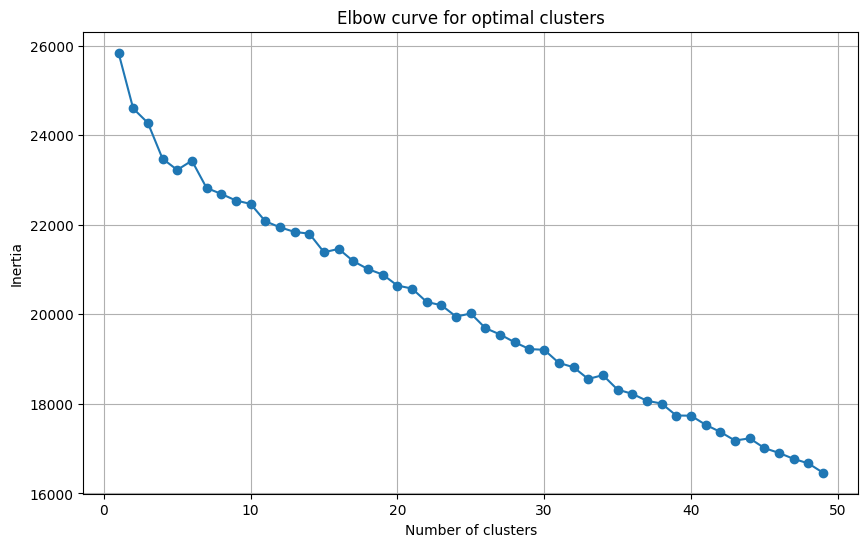

45457.009 --> 23615.960 --> 23381.088 --> 23166.756 --> 23108.703 --> 23094.926 --> 23094.926 --> 


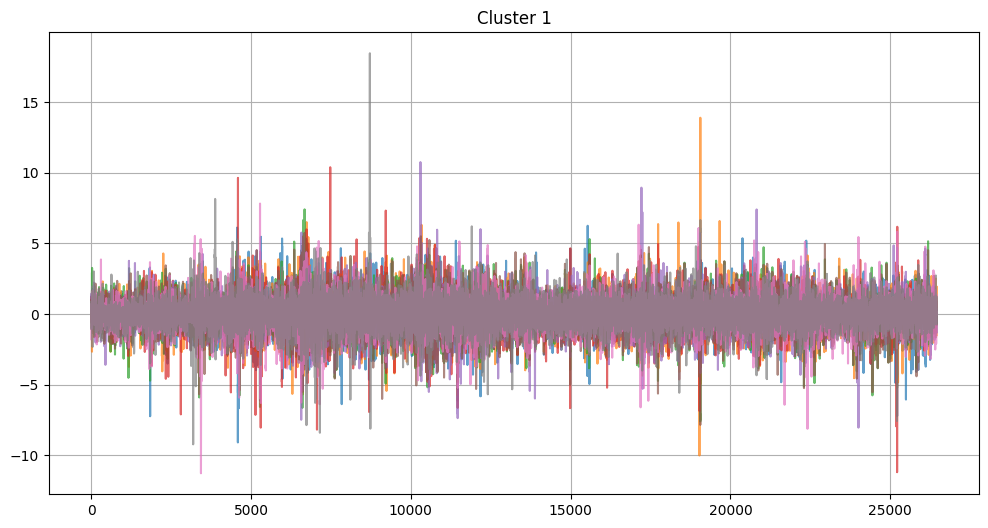

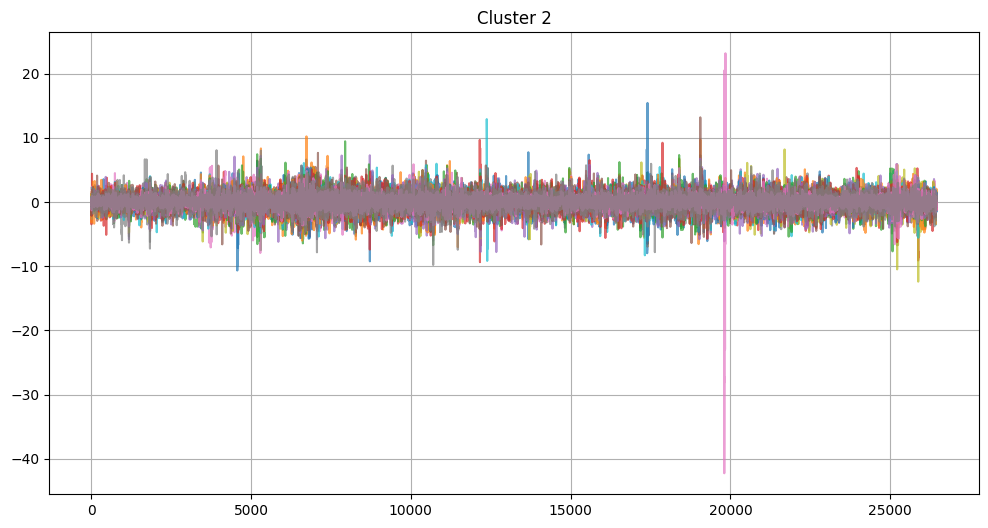

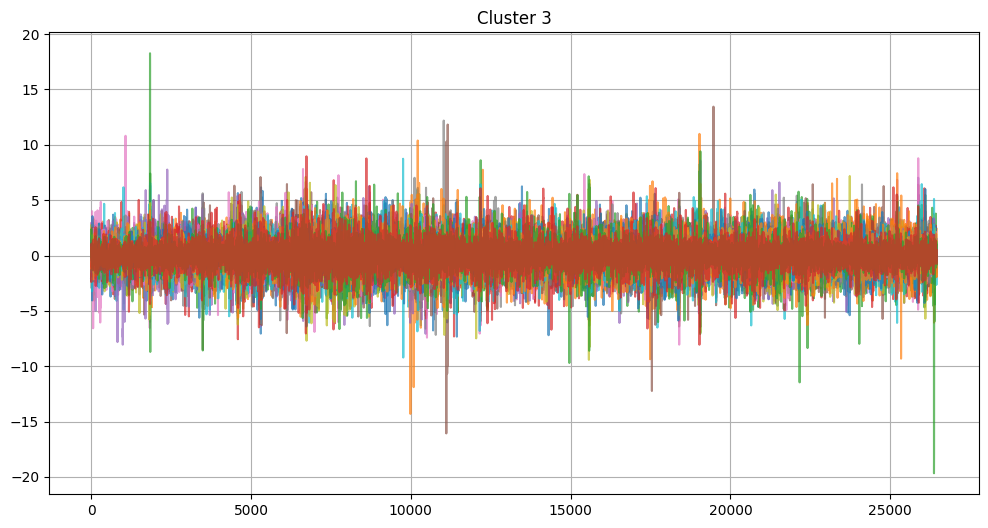

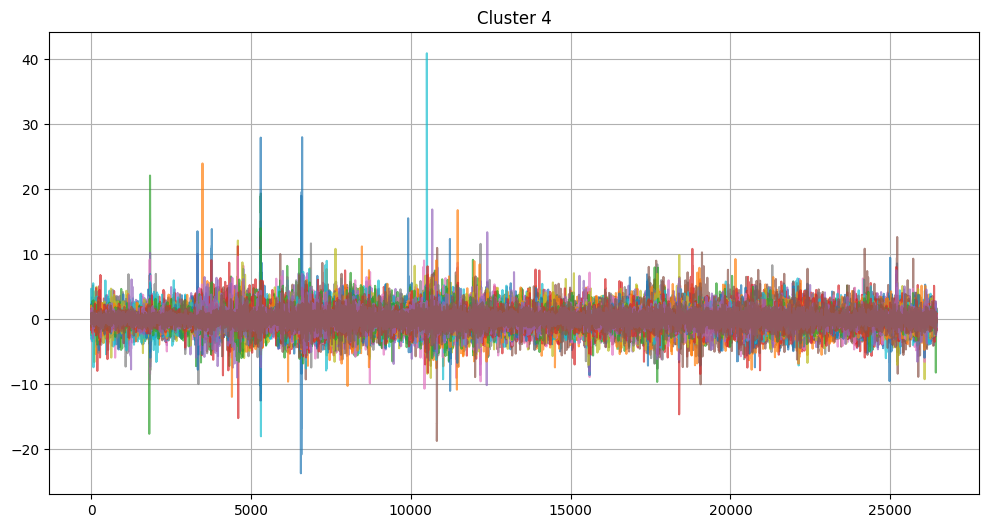

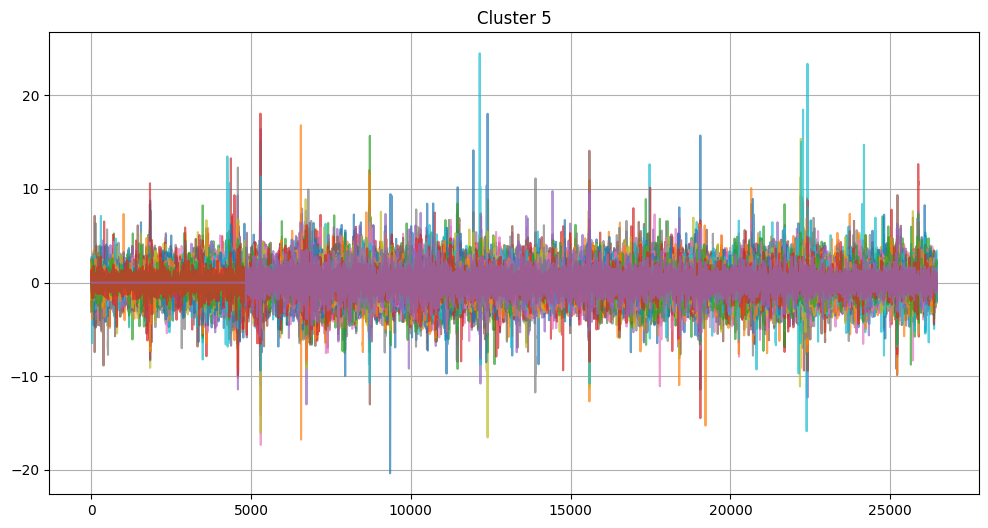

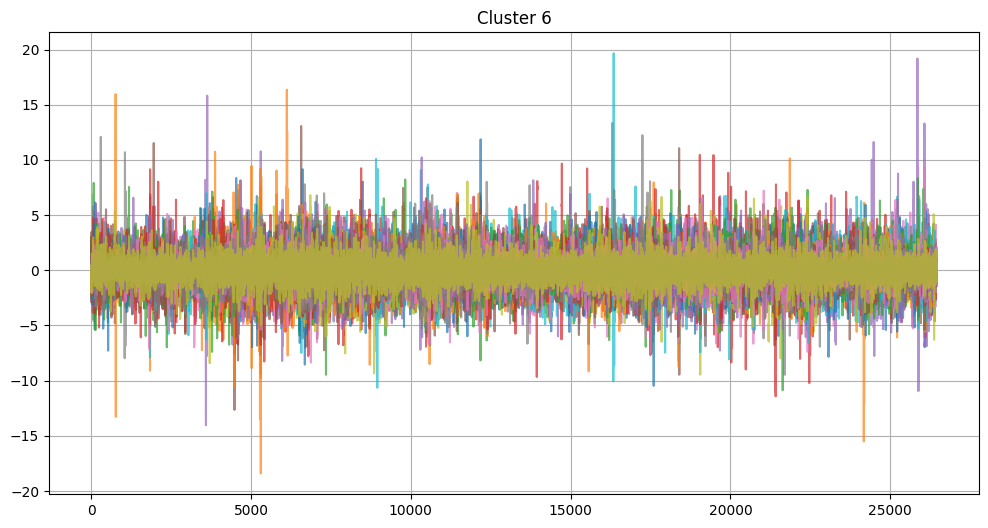

In [20]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# 1. Extract time-series representation of the dataset
time_series_data = df.pivot(index='stock_id', columns='time_id', values='target').fillna(0).values

# Normalizing the time series data
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Ensure zero mean and unit variance
time_series_data_normalized = scaler.fit_transform(time_series_data)

# 2. Plot the elbow curve to determine the optimal number of clusters
inertia = []
max_clusters = 50
for n_clusters in range(1, max_clusters):
    model = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True)
    model.fit(time_series_data_normalized)
    inertia.append(model.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters), inertia, marker='o')
plt.title('Elbow curve for optimal clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# 3. Cluster the data based on the determined optimal number of clusters
n_clusters_optimal = 6
model_optimal = TimeSeriesKMeans(n_clusters=n_clusters_optimal, verbose=True)
labels = model_optimal.fit_predict(time_series_data_normalized)

# Plot each stock's time series, grouped by the predicted cluster assignments
for cluster in range(n_clusters_optimal):
    plt.figure(figsize=(12, 6))
    for series in time_series_data_normalized[labels == cluster]:
        plt.plot(series.ravel(), alpha=0.7)
    plt.title(f'Cluster {cluster + 1}')
    plt.grid(True)
    plt.show()

# Augment the original dataset with the cluster assignments
df['cluster_label'] = df['stock_id'].map({stock_id: label for stock_id, label in zip(df['stock_id'].unique(), labels)})

In [21]:
# import optiver2023
# env = optiver2023.make_env()
# iter_test = env.iter_test()

In [22]:
# if not is_google_colab():
#   counter = 0
#   for (test, revealed_targets, sample_prediction) in iter_test:
#       sample_prediction['target'] = lr.predict(pipeline.fit_transform(test))
#       env.predict(sample_prediction)
#       counter += 1